In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

### Wrangling
Import data

In [2]:
df = pd.read_csv('Data/raw/alcohol_licenses.csv')
df.rename(columns={'Premise City':'Borough'}, inplace=True)

Filter for relevant data only

In [3]:
#NYC only
boroughs = ['MANHATTAN','BROOKLYN','QUEENS','STATEN ISLAND', 'BRONX','NEW YORK']
nyc = df[df['Borough'].isin(boroughs)]

# filter out non-onsite licenses, grocery stores are not representative of nightlife.
on_premise_codes = ['VB', 'EB', 'HB', 'CB', 'BP', 'FV', 'MR', 'VL', 'RL', 'HL', 'CL', 'CT', 'EL', 'OP', 'TL', 'BL', 'CR', 'RW', 'HW', 'CW', 'TW', 'SW', 'SH', 'SC', 'TS', 'ZW', 'ZH', 'ZC', 'ZT', 'ZB', 'SB', 'ZL', 'SL', 'WW', 'WC']
nyc = nyc[nyc['License Type Code'].isin(on_premise_codes)]
nyc.reset_index(inplace=True, drop=True)

#Filter for cols of interest
nyc = nyc.loc[:,['Serial Number', 'License Type Code', 'Premise Zip','Georeference', 'Borough']]

#In the map below , when you set the hue to 'Borough', you can clearly see that 'NEW YORK refers to the manhattan borough.
nyc['Borough'] = nyc['Borough'].str.replace('NEW YORK','MANHATTAN')

In [4]:
my_zips = nyc.groupby('Borough')['Premise Zip'].unique()
my_zips = my_zips.loc[['BROOKLYN','MANHATTAN']]

In [5]:
nyc.rename(columns={'Premise Zip':'ZIP','Borough':'BOROUGH'}, inplace=True)

In [6]:
nyc.to_csv('Data/Processed/nyc_licenses.csv', index=False)

### Concentration of licenses per zip

In [7]:
my_zips = nyc.groupby('BOROUGH')['ZIP'].unique()
my_zips = my_zips.loc[['BROOKLYN','MANHATTAN']]

In [8]:
nyc.BOROUGH = nyc.BOROUGH.str.title().str.replace('Staten Island', 'Staten Is')

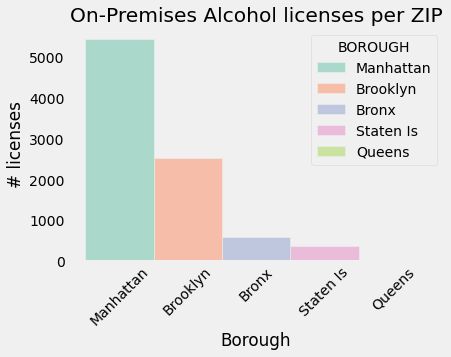

In [9]:
sns.histplot(data=nyc, x='BOROUGH', hue='BOROUGH', palette='Set2')
plt.grid(False)
plt.title('On-Premises Alcohol licenses per ZIP')
plt.xticks(rotation=45)
plt.xlabel('Borough')
plt.ylabel('# licenses')
plt.savefig('Visualizations/licences_per_zip.png', bbox_inches='tight')
plt.show()

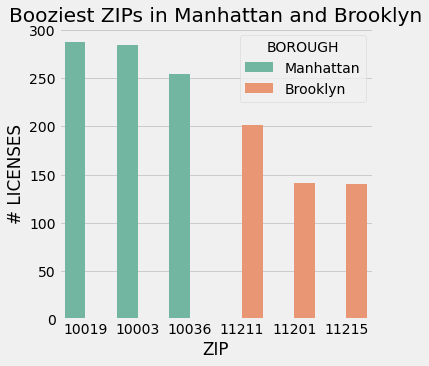

In [10]:
# ZIPs with highest nr licenses in manh and brook
lic_per_zip = (nyc.groupby(['BOROUGH','ZIP'])['Serial Number']
               .count().reset_index())
lic_per_zip = (lic_per_zip.rename(columns={'Serial Number':'# LICENSES'})
               .sort_values('# LICENSES', ascending=False).reset_index(drop=True))

boozy_zips = (pd.concat([lic_per_zip[lic_per_zip['BOROUGH']=='Manhattan'].iloc[:3]
                       ,lic_per_zip[lic_per_zip['BOROUGH']=='Brooklyn'].iloc[:3]]))

plt.figure(figsize=(5,5))
sns.barplot(data=boozy_zips, x='ZIP', y='# LICENSES', hue='BOROUGH', palette='Set2')
plt.title('Booziest ZIPs in Manhattan and Brooklyn')
plt.savefig('Visualizations/relevant_zips.png', bbox_inches='tight')
plt.show()

### Geo

Clean so we can map

In [11]:
#Look at georeferences, it seems to be only 4% so I will ignore them for map visualization purposes
nr_geo_nan = (nyc['Georeference'].isna().sum())/nyc.Georeference.count()
nyc_geo = nyc[nyc.Georeference.notna()]
nyc_geo.to_csv('Data/Processed/nyc_lic_geo.csv', index=False)

In [12]:
# Clean 'Georeference' column and create 'Latitude' and 'Longitude' int columns.
geo_col = nyc_geo.Georeference
geo_clean1 = geo_col.str.replace('POINT ','')
geo_clean2 = geo_clean1.str.replace('(','').str.replace(')','')

coords = geo_clean2.str.split(expand=True)
longit = coords.iloc[:,0]
lat = coords.iloc[:,1]

nyc_geo['Latitude'] = lat.astype('float64')
nyc_geo['Longitude'] = longit.astype('float64')

### Map

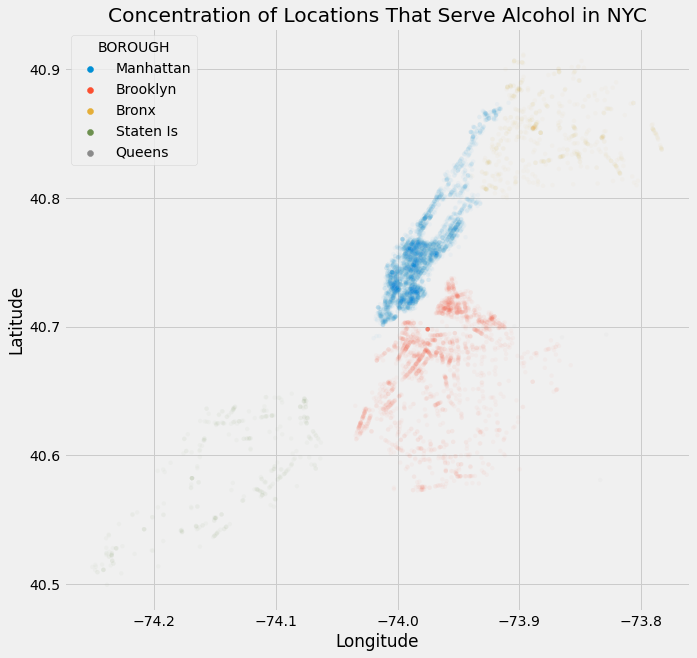

In [13]:
# Filter out outlier
outlier = nyc_geo[nyc_geo.Latitude>42]
outlier

#Map
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='BOROUGH', s=20, data=nyc_geo, alpha=.03)
plt.title('Concentration of Locations That Serve Alcohol in NYC')
plt.savefig('Visualizations/alcohol_scatter.png', bbox_inches='tight')
#Possible parameter: hue='Premise Zip'

### Export

In [14]:
lic_per_zip.to_csv('Data/Processed/lic_per_zip.csv', index=False)